In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from scipy.stats import kurtosis
from scipy.stats import skew
import csv

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [10]:
# Change this cell to the easiest way to load the dataset

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data.csv")
df.head(5)

Mounted at /content/drive


,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,roloff_kurtosis,roloff_skew,flux_max,flux_min,flux_mean,flux_std,flux_kurtosis,flux_skew,rmse_max,rmse_min,rmse_mean,rmse_std,rmse_kurtosis,rmse_skew,zcr_max,zcr_min,zcr_mean,zcr_std,zcr_kurtosis,zcr_skew,contrast_max,contrast_min,contrast_mean,contrast_std,contrast_kurtosis,contrast_skew,bandwidth_max,bandwidth_min,bandwidth_mean,bandwidth_std,...,mfcc_6_kurtosis,mfcc_6_skew,mfcc_7_max,mfcc_7_min,mfcc_7_mean,mfcc_7_std,mfcc_7_kurtosis,mfcc_7_skew,mfcc_8_max,mfcc_8_min,mfcc_8_mean,mfcc_8_std,mfcc_8_kurtosis,mfcc_8_skew,mfcc_9_max,mfcc_9_min,mfcc_9_mean,mfcc_9_std,mfcc_9_kurtosis,mfcc_9_skew,mfcc_10_max,mfcc_10_min,mfcc_10_mean,mfcc_10_std,mfcc_10_kurtosis,mfcc_10_skew,mfcc_11_max,mfcc_11_min,mfcc_11_mean,mfcc_11_std,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,4031.364538,1027.079258,1784.420446,360.263361,5.246790,1.537974,7644.287109,1830.322266,3806.485316,949.558806,1.507485,1.011686,10.981944,0.0,1.391008,1.481524,5.030479,2.113917,0.324014,0.022933,0.130225,0.053187,-0.032982,0.503164,0.242676,0.033203,0.083066,0.027690,3.904819,1.428553,48.289165,4.028252,20.530733,8.761009,1.002488,1.393933,3220.590296,1306.709966,2002.650192,293.081963,...,-0.044964,0.022212,43.634895,-10.577637,15.344631,8.305549,-0.042878,0.040176,13.907670,-38.793354,-12.285267,9.061618,-0.368435,-0.202331,39.424347,-14.338533,10.980492,7.963517,0.339515,0.126730,15.191152,-33.125565,-8.324325,7.862141,-0.179061,0.002401,31.242996,-12.483559,8.810669,7.157400,-0.189109,-0.110339,22.482096,-26.569305,-3.667368,6.422199,0.313302,-0.037197,123.046875,blues
1,5444.293577,421.091729,1529.835316,613.175361,4.028086,1.339397,8085.717773,333.764648,3548.820207,1725.249654,-0.647548,0.447830,17.791128,0.0,1.444008,1.996799,12.743418,3.142622,0.271687,0.004361,0.095918,0.048718,-0.058206,0.299131,0.323730,0.006348,0.056044,0.038059,9.193445,2.362931,48.775996,5.534489,20.676334,8.239387,1.531287,1.428818,3402.554398,1046.389224,2038.617579,462.379133,...,-0.036739,-0.257875,57.322296,-14.032225,23.358673,11.936523,-0.051591,0.107448,21.894630,-52.369705,-10.103617,12.894725,-0.527936,0.009104,40.404282,-29.546383,11.903745,10.219956,0.305566,-0.183417,24.502064,-37.257187,-5.560388,10.262492,0.172146,0.013335,37.242592,-25.349421,5.376803,9.812361,0.054884,0.154526,19.230034,-27.189579,-2.239120,8.055376,-0.182963,0.004210,107.666016,blues
2,4669.770713,417.254802,1552.481958,395.634070,11.609763,1.930126,6556.860352,441.430664,3040.514948,884.938380,0.874197,0.613992,14.719387,0.0,1.638258,1.950675,8.131657,2.490637,0.326591,0.039753,0.175573,0.052423,-0.368472,0.220822,0.440918,0.012695,0.076301,0.031738,37.723069,4.185323,67.980056,4.558865,22.197265,8.727204,0.133514,0.939986,2662.739385,960.211956,1747.165985,275.765675,...,0.407629,0.056905,34.020233,-31.285770,11.629271,10.323797,1.380379,-0.974517,29.949429,-34.671497,-11.780589,8.098292,1.932035,0.884382,31.050621,-33.708015,9.706443,8.235600,2.533789,-0.926742,13.120670,-45.190308,-13.123111,7.596487,0.946092,-0.139495,25.241779,-32.569252,5.789265,8.033045,0.542265,-0.682770,23.078028,-28.854303,-8.905224,7.774160,0.489465,0.710559,161.499023,blues
3,3236.442116,318.713500,1070.119953,429.532791,1.803354,1.001449,7611.987305,387.597656,2185.028454,1222.395194,1.608416,1.245734,14.619911,0.0,1.247379,1.750351,12.675188,3.203631,0.383715,0.009310,0.141191,0.079617,-0.381391,0.525917,0.145020,0.006348,0.033309,0.020569,2.017897,1.072661,53.952526,5.438508,21.428764,7.962859,-0.023194,0.871523,3174.579278,671.098012,1596.333948,408.119547,...,0.366743,-0.887007,30.783287,-18.335241,9.297966,9.008867,-0.251997,-0.328338,25.273712,-29.548191,-0.757742,9.601001,-0.467246,-0.325538,32.761795,-29.347542,8.149013,8.438341,1.682580,-0.656629,25.346262,-45.598274,-3.196314,10.502338,0.191070,-0.346805,40

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.019s...
[t-SNE] Computed neighbors for 1000 samples in 0.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.325157
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.719681
[t-SNE] KL divergence after 1000 iterations: 1.020810
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


Text(0.5, 1.0, 'Embedded space with LDA')

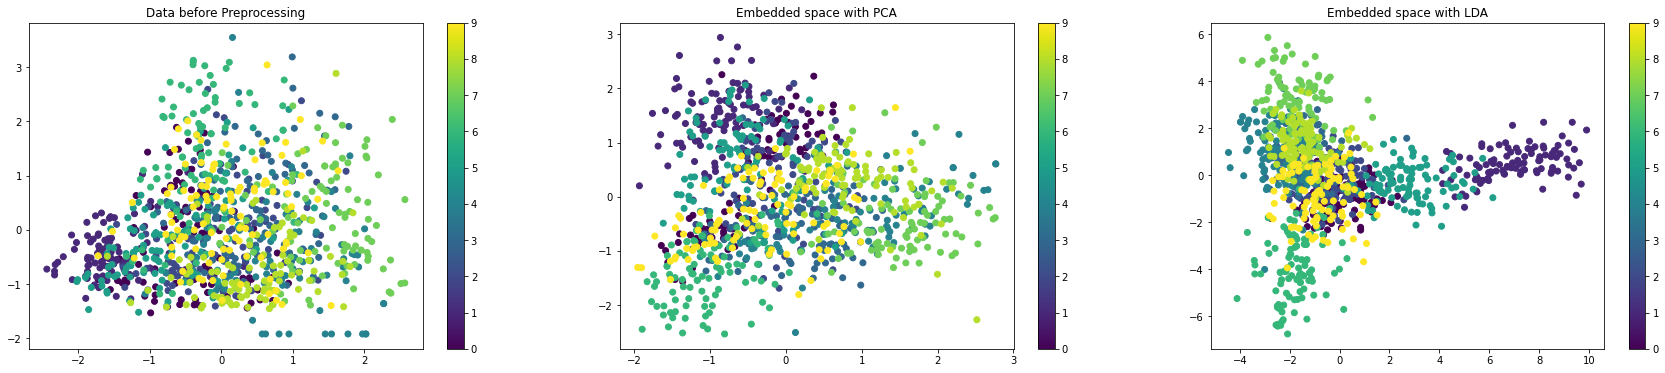

In [4]:
# Data from Dataframe
X = df.drop(['genre'], axis=1)
y = df['genre']

# Scaling X Data
scale = StandardScaler()
x_scaled = pd.DataFrame(scale.fit_transform(X), columns = X.columns)

# Encoding Y Data to integer from 0-9
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

#Performing LDA
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y_enc)

#Performing PCA
pca = PCA(n_components=None, whiten=True)
x_pca = pca.fit_transform(x_scaled)

#Performing t-SNE
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_enc, test_size=0.25, random_state=42)
x_train_lda, x_test_lda, y_train_lda, y_test_lda = train_test_split(x_lda, y_enc, test_size=0.25, random_state=42)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y_enc, test_size=0.25, random_state=42)
x_train_tsne, x_test_tsne, y_train_tsne, y_test_tsne = train_test_split(x_tsne, y_enc, test_size=0.25, random_state=42)

# User for iterations below
dataset = []
dataset.append([x_train, x_test, y_train, y_test])
dataset.append([x_train_lda, x_test_lda, y_train_lda, y_test_lda])
dataset.append([x_train_pca, x_test_pca, y_train_pca, y_test_pca])
dataset.append([x_train_tsne, x_test_tsne, y_train_tsne, y_test_tsne])
xtrain, xtest, ytrain, ytest = range(0,4)

print(np.unique(encoder.inverse_transform(y_enc)))
plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.scatter(x_scaled.iloc[:,0], x_scaled.iloc[:,1], c=y_enc)
plt.colorbar()
plt.title("Data before Preprocessing")

plt.subplot(132)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_enc)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(133)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y_enc)
plt.colorbar()
plt.title("Embedded space with LDA")


# x_train.shape

In [5]:
# First Model: LogisticRegression:
lr_accuracy = []
for data in dataset:
  lr = LogisticRegression(max_iter=1500, random_state=42)
  lr.fit(data[xtrain], data[ytrain])
  lr_accuracy.append(accuracy_score(data[ytest], lr.predict(data[xtest])))

print('LogisticRegression           : {0:.3f}'.format(lr_accuracy[0]))
print('LogisticRegression with LDA  : {0:.3f}'.format(lr_accuracy[1]))
print('LDA resulted in a {0:.3f} point increase ({1:.2%}).'.format(lr_accuracy[1]-lr_accuracy[0], (lr_accuracy[1]/lr_accuracy[0])-1))
print('LogisticRegression with PCA  : {0:.3f}'.format(lr_accuracy[2]))
print('PCA resulted in a {0:.3f} point increase ({1:.2%}).'.format(lr_accuracy[2]-lr_accuracy[0], (lr_accuracy[2]/lr_accuracy[0])-1))
print('LogisticRegression with t-SNE: {0:.3f}'.format(lr_accuracy[3]))
print('t-SNE resulted in a {0:.3f} point increase ({1:.2%}).'.format(lr_accuracy[3]-lr_accuracy[0], (lr_accuracy[3]/lr_accuracy[0])-1))

LogisticRegression           : 0.776
LogisticRegression with LDA  : 0.864
LDA resulted in a 0.088 point increase (11.34%).
LogisticRegression with PCA  : 0.720
PCA resulted in a -0.056 point increase (-7.22%).
LogisticRegression with t-SNE: 0.424
t-SNE resulted in a -0.352 point increase (-45.36%).


In [6]:
# Second Model: RandomForestClassifier
rfc_accuracy = []
for data in dataset:
  rfc = RandomForestClassifier(random_state=42)
  rfc.fit(data[xtrain], data[ytrain])
  rfc_accuracy.append(accuracy_score(data[ytest], rfc.predict(data[xtest])))

print('RandomForestClassifier           : {0:.3f}'.format(rfc_accuracy[0]))
print('RandomForestClassifier with LDA  : {0:.3f}'.format(rfc_accuracy[1]))
print('LDA resulted in a {0:.3f} point increase ({1:.2%}).'.format(rfc_accuracy[1]-rfc_accuracy[0], (rfc_accuracy[1]/rfc_accuracy[0])-1))
print('RandomForestClassifier with PCA  : {0:.3f}'.format(rfc_accuracy[2]))
print('PCA resulted in a {0:.3f} point increase ({1:.2%}).'.format(rfc_accuracy[2]-rfc_accuracy[0], (rfc_accuracy[2]/rfc_accuracy[0])-1))
print('RandomForestClassifier with t-SNE: {0:.3f}'.format(rfc_accuracy[3]))
print('t_SNE resulted in a {0:.3f} point increase ({1:.2%}).'.format(rfc_accuracy[3]-rfc_accuracy[0], (rfc_accuracy[3]/rfc_accuracy[0])-1))

RandomForestClassifier           : 0.724
RandomForestClassifier with LDA  : 0.852
LDA resulted in a 0.128 point increase (17.68%).
RandomForestClassifier with PCA  : 0.680
PCA resulted in a -0.044 point increase (-6.08%).
RandomForestClassifier with t-SNE: 0.644
t_SNE resulted in a -0.080 point increase (-11.05%).


In [7]:
# Third Model: NaiveBayes
gnb_accuracy = []
for data in dataset:
  gnb = GaussianNB()
  gnb.fit(data[xtrain], data[ytrain])
  gnb_accuracy.append(accuracy_score(data[ytest], gnb.predict(data[xtest])))

print('NaiveBayes           : {0:.3f}'.format(gnb_accuracy[0]))
print('NaiveBayes with LDA  : {0:.3f}'.format(gnb_accuracy[1]))
print('LDA resulted in a {0:.3f} point increase ({1:.2%}).'.format(gnb_accuracy[1]-gnb_accuracy[0], (gnb_accuracy[1]/gnb_accuracy[0])-1))
print('NaiveBayes with PCA  : {0:.3f}'.format(gnb_accuracy[2]))
print('PCA resulted in a {0:.3f} point increase ({1:.2%}).'.format(gnb_accuracy[2]-gnb_accuracy[0], (gnb_accuracy[2]/gnb_accuracy[0])-1))
print('NaiveBayes with t-SNE: {0:.3f}'.format(gnb_accuracy[3]))
print('t_SNE resulted in a {0:.3f} point increase ({1:.2%}).'.format(gnb_accuracy[3]-gnb_accuracy[0], (gnb_accuracy[3]/gnb_accuracy[0])-1))

NaiveBayes           : 0.552
NaiveBayes with LDA  : 0.880
LDA resulted in a 0.328 point increase (59.42%).
NaiveBayes with PCA  : 0.604
PCA resulted in a 0.052 point increase (9.42%).
NaiveBayes with t-SNE: 0.396
t_SNE resulted in a -0.156 point increase (-28.26%).


In [8]:
# Fourth Model: SGDClassifier
sgd_accuracy = []
for data in dataset:
  sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=2000, random_state=42)
  sgd.fit(data[xtrain], data[ytrain])
  sgd_accuracy.append(accuracy_score(data[ytest], sgd.predict(data[xtest])))

print('SGDClassifier           : {0:.3f}'.format(sgd_accuracy[0]))
print('SGDClassifier with LDA  : {0:.3f}'.format(sgd_accuracy[1]))
print('LDA resulted in a {0:.3f} point increase ({1:.2%}).'.format(sgd_accuracy[1]-sgd_accuracy[0], (sgd_accuracy[1]/sgd_accuracy[0])-1))
print('SGDClassifier with PCA  : {0:.3f}'.format(sgd_accuracy[2]))
print('PCA resulted in a {0:.3f} point increase ({1:.2%}).'.format(sgd_accuracy[2]-sgd_accuracy[0], (sgd_accuracy[2]/sgd_accuracy[0])-1))
print('SGDClassifier with t-SNE: {0:.3f}'.format(sgd_accuracy[3]))
print('t-SNE resulted in a {0:.3f} point increase ({1:.2%}).'.format(sgd_accuracy[3]-sgd_accuracy[0], (sgd_accuracy[3]/sgd_accuracy[0])-1))

SGDClassifier           : 0.728
SGDClassifier with LDA  : 0.808
LDA resulted in a 0.080 point increase (10.99%).
SGDClassifier with PCA  : 0.672
PCA resulted in a -0.056 point increase (-7.69%).
SGDClassifier with t-SNE: 0.212
t-SNE resulted in a -0.516 point increase (-70.88%).


In [9]:
# Final Model: TerasSequential
epochs = 20
batch_size = 64 # On average the best

seq_history = []
seq_accuracy = []
for data in dataset:
  seq = Sequential()
  seq.add(Dense(512, activation='relu', input_shape=(data[xtrain].shape[1],)))
  seq.add(Dense(256, activation='relu'))
  seq.add(Dense(128, activation='relu'))
  seq.add(Dense(64, activation='relu'))
  seq.add(Dense(10, activation='softmax'))

  seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = seq.fit(data[xtrain], data[ytrain], epochs=epochs, batch_size=batch_size, validation_data=(data[xtest], data[ytest]), verbose=0)
  seq_history.append(history)
  test_loss, test_acc = seq.evaluate(data[xtest], data[ytest], verbose=0)
  seq_accuracy.append(test_acc)
  # print(accuracy_score(data[ytest], seq.pre(data[xtest])))

print('TerasSequential           : {0:.3f} (~0.74-0.77 on average)'.format(seq_accuracy[0]))
print('TerasSequential with LDA  : {0:.3f} (~0.84-0.87 on average)'.format(seq_accuracy[1]))
print('LDA resulted in a {0:.3f} point increase ({1:.2%}) (~7-17% on average)'.format(seq_accuracy[1]-seq_accuracy[0], (seq_accuracy[1]/seq_accuracy[0])-1))
print('TerasSequential with PCA  : {0:.3f}'.format(seq_accuracy[2]))
print('PCA resulted in a {0:.3f} point increase ({1:.2%})'.format(seq_accuracy[2]-seq_accuracy[0], (seq_accuracy[2]/seq_accuracy[0])-1))
print('TerasSequential with t-SNE: {0:.3f}'.format(seq_accuracy[3]))
print('t-SNE resulted in a {0:.3f} point increase ({1:.2%})'.format(seq_accuracy[3]-seq_accuracy[0], (seq_accuracy[3]/seq_accuracy[0])-1))

TerasSequential           : 0.772 (~0.74-0.77 on average)
TerasSequential with LDA  : 0.868 (~0.84-0.87 on average)
LDA resulted in a 0.096 point increase (12.44%) (~7-17% on average)
TerasSequential with PCA  : 0.688
PCA resulted in a -0.084 point increase (-10.88%)
TerasSequential with t-SNE: 0.472
t-SNE resulted in a -0.300 point increase (-38.86%)
